In [1]:
# to do: use id to select the sentence to analyze
# to do: use translator to predict sentence
import os
import torch
import time 
import numpy as np
import matplotlib.pyplot as plt
import yaml
from torch.nn.utils.rnn import pad_sequence

from transformer.Models import Transformer
from transformer.Translator import Translator

In [2]:
##### Read Arguments from Config File #####

# config_path = '../configs/base_transformer.yaml'
# config_path = '../configs/dpng_transformer.yaml'
# config_path = '../configs/dpng_transformer_bert_tokenizer_bow.yaml'
# config_path = '../configs/dpng_transformer_bert_tokenizer_bow_indivtopk.yaml'
# config_path = '../configs/dpng_transformer_bert_tokenizer_bow_indivtopk_onlybow.yaml'
# config_path = '../configs/dpng_transformer_bert_tokenizer_bow_indiv_neighbors.yaml'
# config_path = '../configs/dpng_transformer_bert_tokenizer_bow_maskword_indivtopk.yaml'
config_path = '../configs/dpng_transformer_bert_tokenizer_bow_indivtopk_replace_nopreprocess.yaml'


with open(config_path) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    print(config)

save_model_path = config['save_model_path']
output_file = config['test_output_file']
use_dataset = config['dataset']

batch_size = 1

d_model = config['d_model']
d_inner_hid = config['d_inner_hid']
d_k = config['d_k']
d_v = config['d_v']

n_head = config['n_head']
n_layers = config['n_layers']
n_warmup_steps = config['n_warmup_steps']

dropout = config['dropout']
embs_share_weight = config['embs_share_weight']
proj_share_weight = config['proj_share_weight']
label_smoothing = config['label_smoothing']

train_size = config['train_size']
val_size = config['val_size']
test_size = config['test_size']

beam_size = 1
max_seq_len = 30

try:
    is_bow = config['is_bow']

    if is_bow:
        bow_strategy = config['bow_strategy']
        topk = config['topk']
        if bow_strategy != 'simple_sum':
            indiv_topk = config['indiv_topk']
        else:
            # not used but use default value for simplicity
            indiv_topk = 50

except KeyError:
    is_bow = False
    
try:
    is_bow = config['is_bow']

    if is_bow:
        bow_strategy = config['bow_strategy']
        topk = config['topk']
        if bow_strategy != 'simple_sum':
            indiv_topk = config['indiv_topk']
        else:
            # not used but use default value for simplicity
            indiv_topk = 50
        
        only_bow = config['only_bow']
        replace_predict = config['replace_predict']

except KeyError:
    is_bow = False
    
# ###################

{'save_model_path': '../models/DNPG_base_transformer_bert_tokenizer_bert_bow_indivtopk_replace_nopreprocess.pth', 'log_file': '../logs/DNPG_base_transformer_bert_tokenizer_training_bert_bow_indiv_topk_replace_nopreprocess.txt', 'test_output_file': '../outputs/test_DNPG_transformer_bert_tokenizer_bow_indivtopk_replace_out_nopreprocess.txt', 'val_output_file': '../outputs/val_DNPG_transformer_bert_tokenizer_bow_indivtopk_replace_out_nopreprocess.txt', 'dataset': 'quora_bert_mask_predict_dataset', 'num_epochs': 50, 'batch_size': 100, 'd_model': 450, 'd_inner_hid': 512, 'd_k': 50, 'd_v': 50, 'n_head': 9, 'n_layers': 3, 'n_warmup_steps': 12000, 'dropout': 0.1, 'embs_share_weight': True, 'proj_share_weight': True, 'label_smoothing': False, 'train_size': 100000, 'val_size': 4000, 'test_size': 20000, 'is_bow': True, 'bow_strategy': 'indiv_topk', 'indiv_topk': 10, 'topk': 50, 'lr': '1e-3', 'only_bow': False, 'replace_predict': True}


In [3]:
preprocessed = False

In [4]:
# load dataset
if preprocessed:
    from datasets.quora_preprocessed_dataset import QuoraPreprocessedDataset as Dataset
else:
    if use_dataset == 'quora_dataset':
        from datasets.quora_dataset import QuoraDataset as Dataset
    elif use_dataset == 'quora_bert_dataset':
        from datasets.quora_bert_dataset import QuoraBertDataset as Dataset
    elif use_dataset == 'quora_bert_mask_predict_dataset':
        from datasets.quora_bert_mask_predict_dataset import QuoraBertMaskPredictDataset as Dataset
    elif use_dataset == 'quora_word_mask_prediction_dataset':
        from datasets.quora_word_mask_prediction_dataset import QuoraWordMaskPredictDataset as Dataset
    else:
        raise NotImplementedError("Dataset is not defined or not implemented")
        



In [5]:
# Force not to replace when predicting
replace_predict = False

if preprocessed:
    model_name = config_path.split('/')[-1][:-5]
    preprocessed_file = '../data/preprocess_all_{}.npy'.format(model_name)
    dataset = Dataset("test", train_size, val_size, test_size, preprocessed_file=preprocessed_file)
elif is_bow:
    dataset = Dataset(
        "test", train_size, val_size, test_size, bow_strategy=bow_strategy, topk=topk, 
        indiv_topk=indiv_topk, only_bow=only_bow, use_origin=only_bow, replace_predict=replace_predict
    )
else:
    dataset = Dataset("test", train_size, val_size, test_size)



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transformer = Transformer(
    dataset.n_words,
    dataset.n_words,
    src_pad_idx=dataset.PAD_token_id,
    trg_pad_idx=dataset.PAD_token_id,
    trg_emb_prj_weight_sharing=proj_share_weight,
    emb_src_trg_weight_sharing=embs_share_weight,
    d_k=d_k,
    d_v=d_v,
    d_model=d_model,
    d_word_vec=d_model,
    d_inner=d_inner_hid,
    n_layers=n_layers,
    n_head=n_head,
    dropout=dropout    
)

model = transformer.to(device)

model.load_state_dict((torch.load(
        save_model_path, map_location=device)))

model.eval()

Transformer(
  (encoder): Encoder(
    (src_word_emb): Embedding(28996, 450, padding_idx=0)
    (position_enc): PositionalEncoding()
    (dropout): Dropout(p=0.1, inplace=False)
    (layer_stack): ModuleList(
      (0): EncoderLayer(
        (slf_attn): MultiHeadAttention(
          (w_qs): Linear(in_features=450, out_features=450, bias=False)
          (w_ks): Linear(in_features=450, out_features=450, bias=False)
          (w_vs): Linear(in_features=450, out_features=450, bias=False)
          (fc): Linear(in_features=450, out_features=450, bias=False)
          (attention): ScaledDotProductAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (dropout): Dropout(p=0.1, inplace=False)
          (layer_norm): LayerNorm((450,), eps=1e-06, elementwise_affine=True)
        )
        (pos_ffn): PositionwiseFeedForward(
          (w_1): Linear(in_features=450, out_features=512, bias=True)
          (w_2): Linear(in_features=512, out_features=450, bias=True)
  

In [7]:
''' This module will handle the text generation with beam search. '''

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformer.Models import Transformer, get_pad_mask, get_subsequent_mask


class Translator(nn.Module):
    ''' Load a trained model and translate in beam search fashion. '''

    def __init__(
            self, model, beam_size, max_seq_len,
            src_pad_idx, trg_pad_idx, trg_bos_idx, trg_eos_idx):
        

        super(Translator, self).__init__()

        self.alpha = 0.7
        self.beam_size = beam_size
        self.max_seq_len = max_seq_len
        self.src_pad_idx = src_pad_idx
        self.trg_bos_idx = trg_bos_idx
        self.trg_eos_idx = trg_eos_idx

        self.model = model
        self.model.eval()

        self.register_buffer('init_seq', torch.LongTensor([[trg_bos_idx]]))
        self.register_buffer(
            'blank_seqs', 
            torch.full((beam_size, max_seq_len), trg_pad_idx, dtype=torch.long))
        self.blank_seqs[:, 0] = self.trg_bos_idx
        self.register_buffer(
            'len_map', 
            torch.arange(1, max_seq_len + 1, dtype=torch.long).unsqueeze(0))


    def _model_decode(self, trg_seq, enc_output, src_mask):
        trg_mask = get_subsequent_mask(trg_seq)
#         dec_output, *_ = self.model.decoder(trg_seq, trg_mask, enc_output, src_mask, return_attns=True)
        dec_output, dec_slf_attn_list, dec_enc_attn_list = self.model.decoder(trg_seq, trg_mask, enc_output, src_mask, return_attns=True)
        
        return F.softmax(self.model.trg_word_prj(dec_output), dim=-1), dec_enc_attn_list


    def _get_init_state(self, src_seq, src_mask):
        beam_size = self.beam_size

        enc_output, *_ = self.model.encoder(src_seq, src_mask)
        dec_output, dec_enc_attn_list = self._model_decode(self.init_seq, enc_output, src_mask)
        
        best_k_probs, best_k_idx = dec_output[:, -1, :].topk(beam_size)

        scores = torch.log(best_k_probs).view(beam_size)
        gen_seq = self.blank_seqs.clone().detach()
        gen_seq[:, 1] = best_k_idx[0]
        enc_output = enc_output.repeat(beam_size, 1, 1)
        return enc_output, gen_seq, scores, dec_enc_attn_list


    def _get_the_best_score_and_idx(self, gen_seq, dec_output, scores, step):
        assert len(scores.size()) == 1
        
        beam_size = self.beam_size

        # Get k candidates for each beam, k^2 candidates in total.
        best_k2_probs, best_k2_idx = dec_output[:, -1, :].topk(beam_size)

        # Include the previous scores.
        scores = torch.log(best_k2_probs).view(beam_size, -1) + scores.view(beam_size, 1)

        # Get the best k candidates from k^2 candidates.
        scores, best_k_idx_in_k2 = scores.view(-1).topk(beam_size)
 
        # Get the corresponding positions of the best k candidiates.
        best_k_r_idxs, best_k_c_idxs = best_k_idx_in_k2 // beam_size, best_k_idx_in_k2 % beam_size
        best_k_idx = best_k2_idx[best_k_r_idxs, best_k_c_idxs]

        # Copy the corresponding previous tokens.
        gen_seq[:, :step] = gen_seq[best_k_r_idxs, :step]
        # Set the best tokens in this beam search step
        gen_seq[:, step] = best_k_idx

        return gen_seq, scores


    def translate_sentence(self, src_seq, return_attn=False):
        # Only accept batch size equals to 1 in this function.
        # TODO: expand to batch operation.
        assert src_seq.size(0) == 1

        src_pad_idx, trg_eos_idx = self.src_pad_idx, self.trg_eos_idx 
        max_seq_len, beam_size, alpha = self.max_seq_len, self.beam_size, self.alpha 
        
        with torch.no_grad():
        #     pred, enc_slf_attn_list, dec_slf_attn_list, dec_enc_attn_list = model(src_seq, trg_seq, True)
        #     pred_seq = translator.translate_sentence(src_seq)
            src_mask = get_pad_mask(src_seq, src_pad_idx)
            enc_output, gen_seq, scores, dec_enc_attn_list = translator._get_init_state(src_seq, src_mask)

            output_dec_enc_attn = [[] for _ in range(len(dec_enc_attn_list))]
            
            for l in range(len(dec_enc_attn_list)):
                    output_dec_enc_attn[l].append(dec_enc_attn_list[l][0,:,-1,:])    
            ans_idx = 0   # default
            for step in range(2, max_seq_len):    # decode up to max length
                dec_output, dec_enc_attn_list = translator._model_decode(gen_seq[:, :step], enc_output, src_mask)
                gen_seq, scores = translator._get_the_best_score_and_idx(gen_seq, dec_output, scores, step)

                # append dec_enc_attn_list
                for l in range(len(dec_enc_attn_list)):
                    output_dec_enc_attn[l].append(dec_enc_attn_list[l][0,:,-1,:])

                # Check if all path finished
                # -- locate the eos in the generated sequences
                eos_locs = gen_seq == trg_eos_idx   
                # -- replace the eos with its position for the length penalty use
                seq_lens, _ = translator.len_map.masked_fill(~eos_locs, max_seq_len).min(1)
                # -- check if all beams contain eos
                if (eos_locs.sum(1) > 0).sum(0).item() == beam_size:
                    # TODO: Try different terminate conditions.
                    _, ans_idx = scores.div(seq_lens.float() ** alpha).max(0)
                    ans_idx = ans_idx.item()
                    break


        if return_attn:
            for l in range(len(output_dec_enc_attn)):
                output_dec_enc_attn[l] = torch.stack(output_dec_enc_attn[l], dim=1)
            return gen_seq[ans_idx][:seq_lens[ans_idx]].tolist(), output_dec_enc_attn
        return gen_seq[ans_idx][:seq_lens[ans_idx]].tolist()


In [8]:
src_pad_idx = dataset.PAD_token_id
trg_pad_idx = dataset.PAD_token_id
    
trg_bos_idx = dataset.SOS_token_id
trg_eos_idx = dataset.EOS_token_id
unk_idx = dataset.UNK_token_id

# translator = Translator(
#         model=model,
#         beam_size=3,
#         max_seq_len=max_seq_len,
#         src_pad_idx=src_pad_idx,
#         trg_pad_idx=trg_pad_idx,
#         trg_bos_idx=trg_bos_idx,
#         trg_eos_idx=trg_eos_idx).to(device)

translator = Translator(
        model=model,
        beam_size=1,
        max_seq_len=max_seq_len,
        src_pad_idx=src_pad_idx,
        trg_pad_idx=trg_pad_idx,
        trg_bos_idx=trg_bos_idx,
        trg_eos_idx=trg_eos_idx).to(device)


In [9]:
# trans_dec_enc_attn = [[] for _ in range(3)]
# for l in range(len(output_dec_enc_attn)):
#     output_dec_enc_attn[l] = torch.stack(output_dec_enc_attn[l], dim=1)
# # output_dec_enc_attn = torch.stack(output_dec_enc_attn[0], dim=1)
# print(dec_enc_attn_list[0].shape)
# print(dec_enc_attn_list[0][0].shape)

In [10]:

#     def translate_sentence(self, src_seq):
#         # Only accept batch size equals to 1 in this function.
#         # TODO: expand to batch operation.
#         assert src_seq.size(0) == 1

#         src_pad_idx, trg_eos_idx = self.src_pad_idx, self.trg_eos_idx 
#         max_seq_len, beam_size, alpha = self.max_seq_len, self.beam_size, self.alpha 

#         with torch.no_grad():
#             src_mask = get_pad_mask(src_seq, src_pad_idx)
#             enc_output, gen_seq, scores = self._get_init_state(src_seq, src_mask)

#             ans_idx = 0   # default
#             for step in range(2, max_seq_len):    # decode up to max length
#                 dec_output = self._model_decode(gen_seq[:, :step], enc_output, src_mask)
#                 gen_seq, scores = self._get_the_best_score_and_idx(gen_seq, dec_output, scores, step)

#                 # Check if all path finished
#                 # -- locate the eos in the generated sequences
#                 eos_locs = gen_seq == trg_eos_idx   
#                 # -- replace the eos with its position for the length penalty use
#                 seq_lens, _ = self.len_map.masked_fill(~eos_locs, max_seq_len).min(1)
#                 # -- check if all beams contain eos
#                 if (eos_locs.sum(1) > 0).sum(0).item() == beam_size:
#                     # TODO: Try different terminate conditions.
#                     _, ans_idx = scores.div(seq_lens.float() ** alpha).max(0)
#                     ans_idx = ans_idx.item()
#                     break
#         return gen_seq[ans_idx][:seq_lens[ans_idx]].tolist()

In [11]:
def draw_attention(src, output, output_dec_enc_attn, model_name, idx, savefig=False):
    # layers
    # savefig = True
    # model_name = config_path.split('/')[-1][:-5]
    # l: number of layers
    for l in range(3):
        print("Plotting layer {}".format(l))
        fig, ((ax1), (ax2), (ax3), (ax4), (ax5), (ax6), (ax7), (ax8), (ax9)) = plt.subplots(9, 1, figsize=(15, 45))
        axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

        # i: number of heads
        for i in range(len(axes)):
    #         beam_id = 0
    #         attention = dec_enc_attn_list[l][beam_id].cpu()[i]
            attention = output_dec_enc_attn[l][i].cpu()

            ax = axes[i]
            im = ax.imshow(attention, cmap="YlGn")

            # Create colorbar
            cbar = ax.figure.colorbar(im, ax=ax)
            cbar.ax.set_ylabel("weight", rotation=-90, va="bottom")

            ax.set_xticks(np.arange(len(src)))
            ax.set_yticks(np.arange(len(output)))

            ax.set_xticklabels(src)
            ax.set_yticklabels(output)

            plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

            for edge, spine in ax.spines.items():
                spine.set_visible(False)

            ax.set_xticks(np.arange(attention.shape[1]+1)-.5, minor=True)
            ax.set_yticks(np.arange(attention.shape[0]+1)-.5, minor=True)
            ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
            ax.tick_params(which="minor", bottom=False, left=False)
            ax.set_title(f'Head {i}')
            fig.tight_layout()
        plt.tight_layout()
        if savefig:
            output_folder = "../images/{}/idx_{}".format(model_name, idx)
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)

            output_name = "{}/layer_{}".format(output_folder, l)
    #         output_name = "../images/attn_{}_layer_{}.png".format(idx, l)
            plt.savefig(output_name)
            print("Image saved... {}".format(output_name))

In [12]:
def get_src_pred(dataset, idx, config_path):
    # not bert
    if 'bert' not in config_path:
        src = [dataset.idx2word[idx] for idx in src_seq[0].tolist()]
        output = [dataset.idx2word[idx] for idx in pred_seq]
        # output = [dataset.idx2word[idx] for idx in trg_seq[0].tolist()]
        print("src: ", src)
        print("output: ", output)    

    # bert
    else:
        tokenizer = dataset.tokenizer
        src = tokenizer.convert_ids_to_tokens(src_seq[0])
        output = tokenizer.convert_ids_to_tokens(pred_seq)
        target = tokenizer.convert_ids_to_tokens(trg_seq[0])

        print("Src: ", src)
        print("Output: ", output)
        print("Target: ", target)
    return src, output

Src:  ['[CLS]', 'What', 'is', 'the', 'food', 'you', 'can', 'eat', 'every', 'day', 'for', 'breakfast', ',', 'lunch', 'and', 'dinner', '?', '[SEP]', ',', 'dinner', 'lunch', 'breakfast', 'for', '-', 'supper', 'and', 'tea', 'coffee', 'all', 'with', 'that', 'after', 'or', '?', 'this', 'bed', 'dessert', 'meals', ';', 'one', ':', '...', 'day', 'at', 'before', 'about', 'night', 'every', 'morning', 'eat', '.', 'week', 'get', 'is', 'Where', 'each', 'evening', 'year', 'must', 'find', 'of', 'have', 'month', 'you', 'the', 'afternoon', 'cook', 'Sunday', '[SEP]']
Output:  ['[CLS]', 'What', 'is', 'the', 'best', 'food', 'you', 'can', 'eat', 'every', 'day', 'for', 'breakfast', ',', 'esteem', 'and', 'dinner', '?', '[SEP]']
Target:  ['[CLS]', 'Is', 'it', 'healthy', 'to', 'eat', 'fish', 'every', 'day', '?']
Plotting layer 0
Image saved... ../images/dpng_transformer_bert_tokenizer_bow_indivtopk_replace_nopreprocess/idx_0/layer_0
Plotting layer 1
Image saved... ../images/dpng_transformer_bert_tokenizer_bow_i

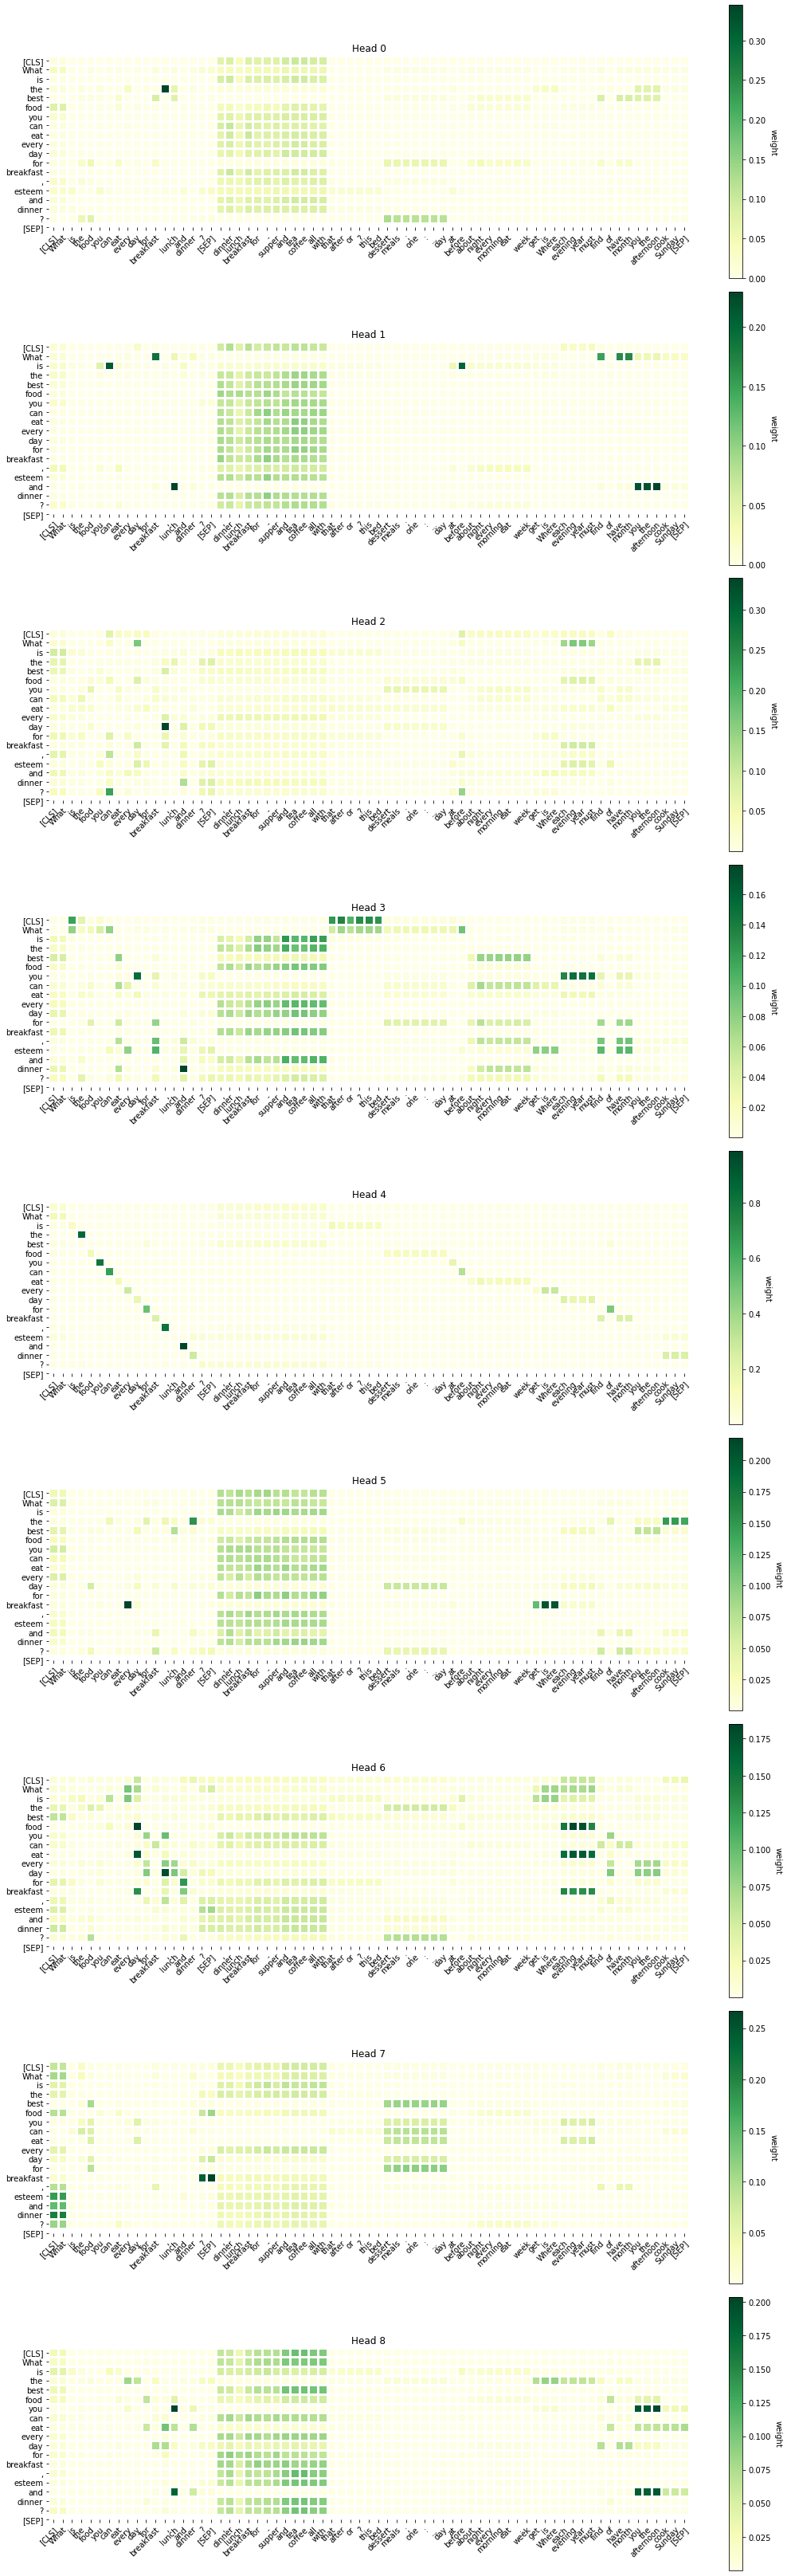

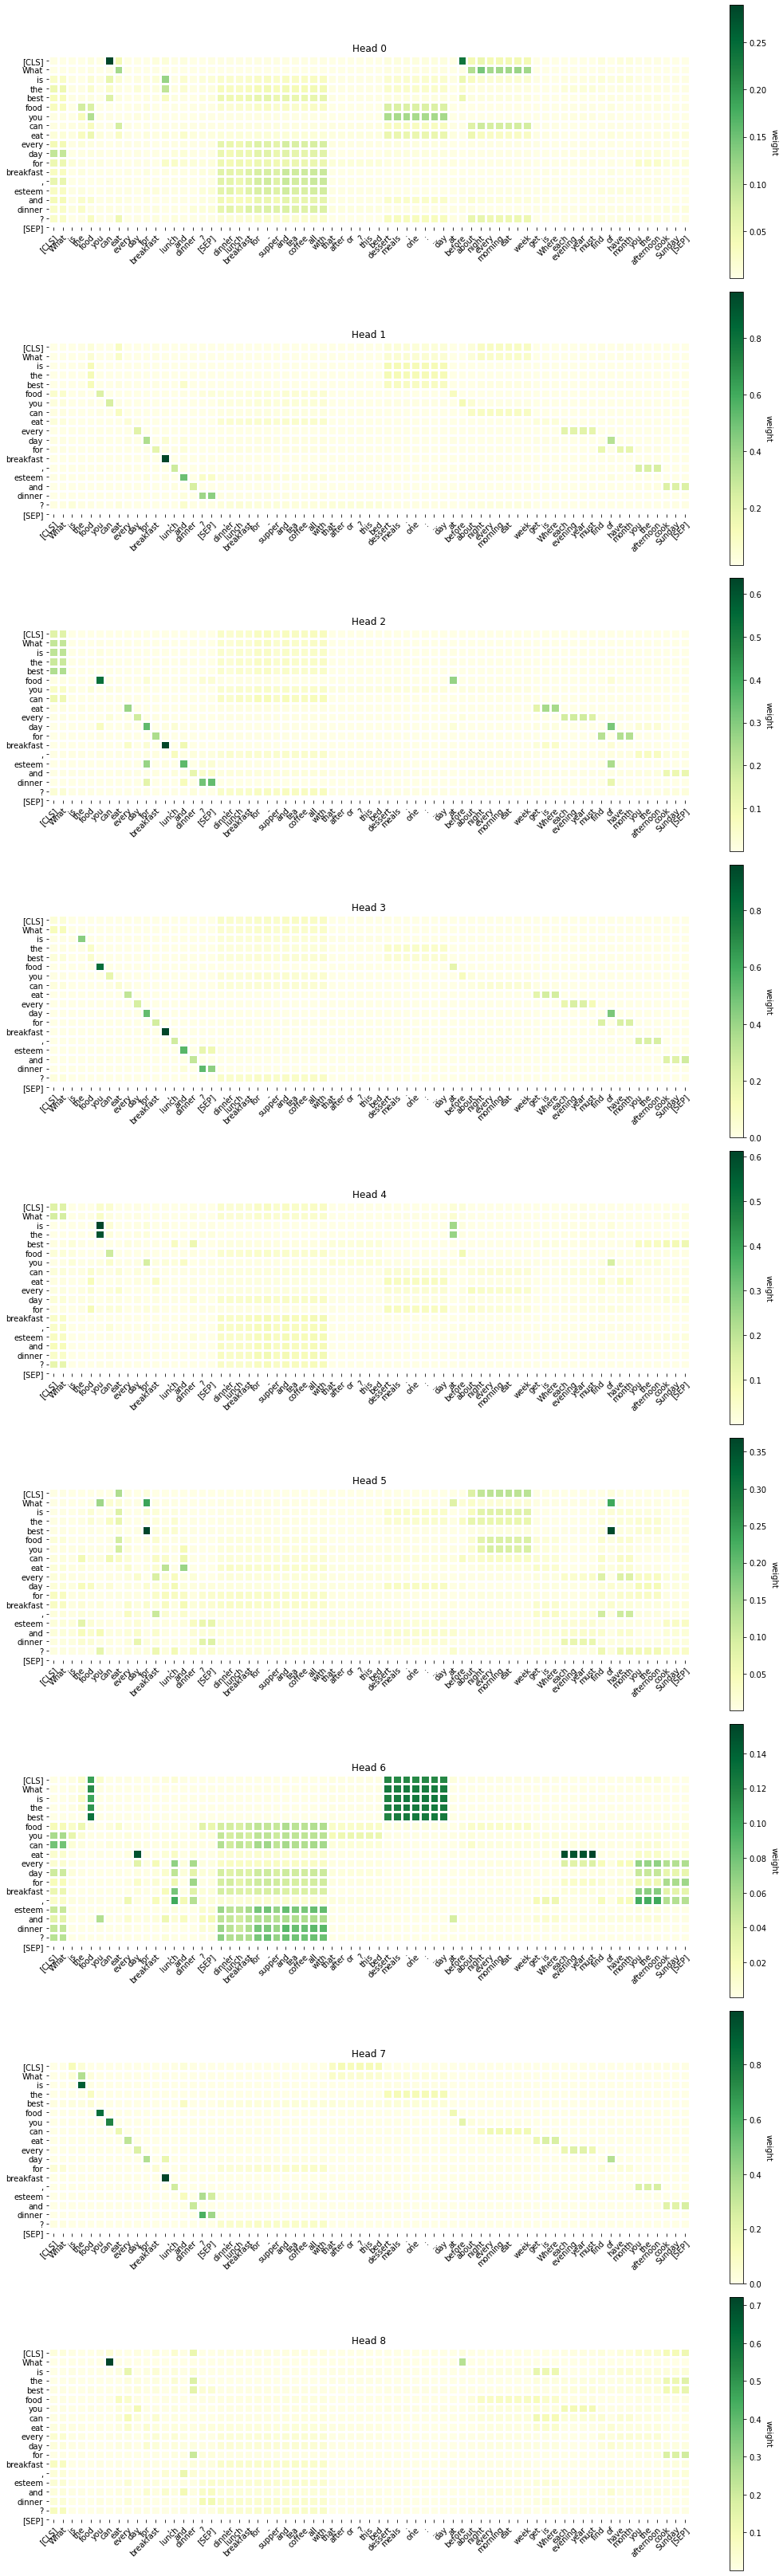

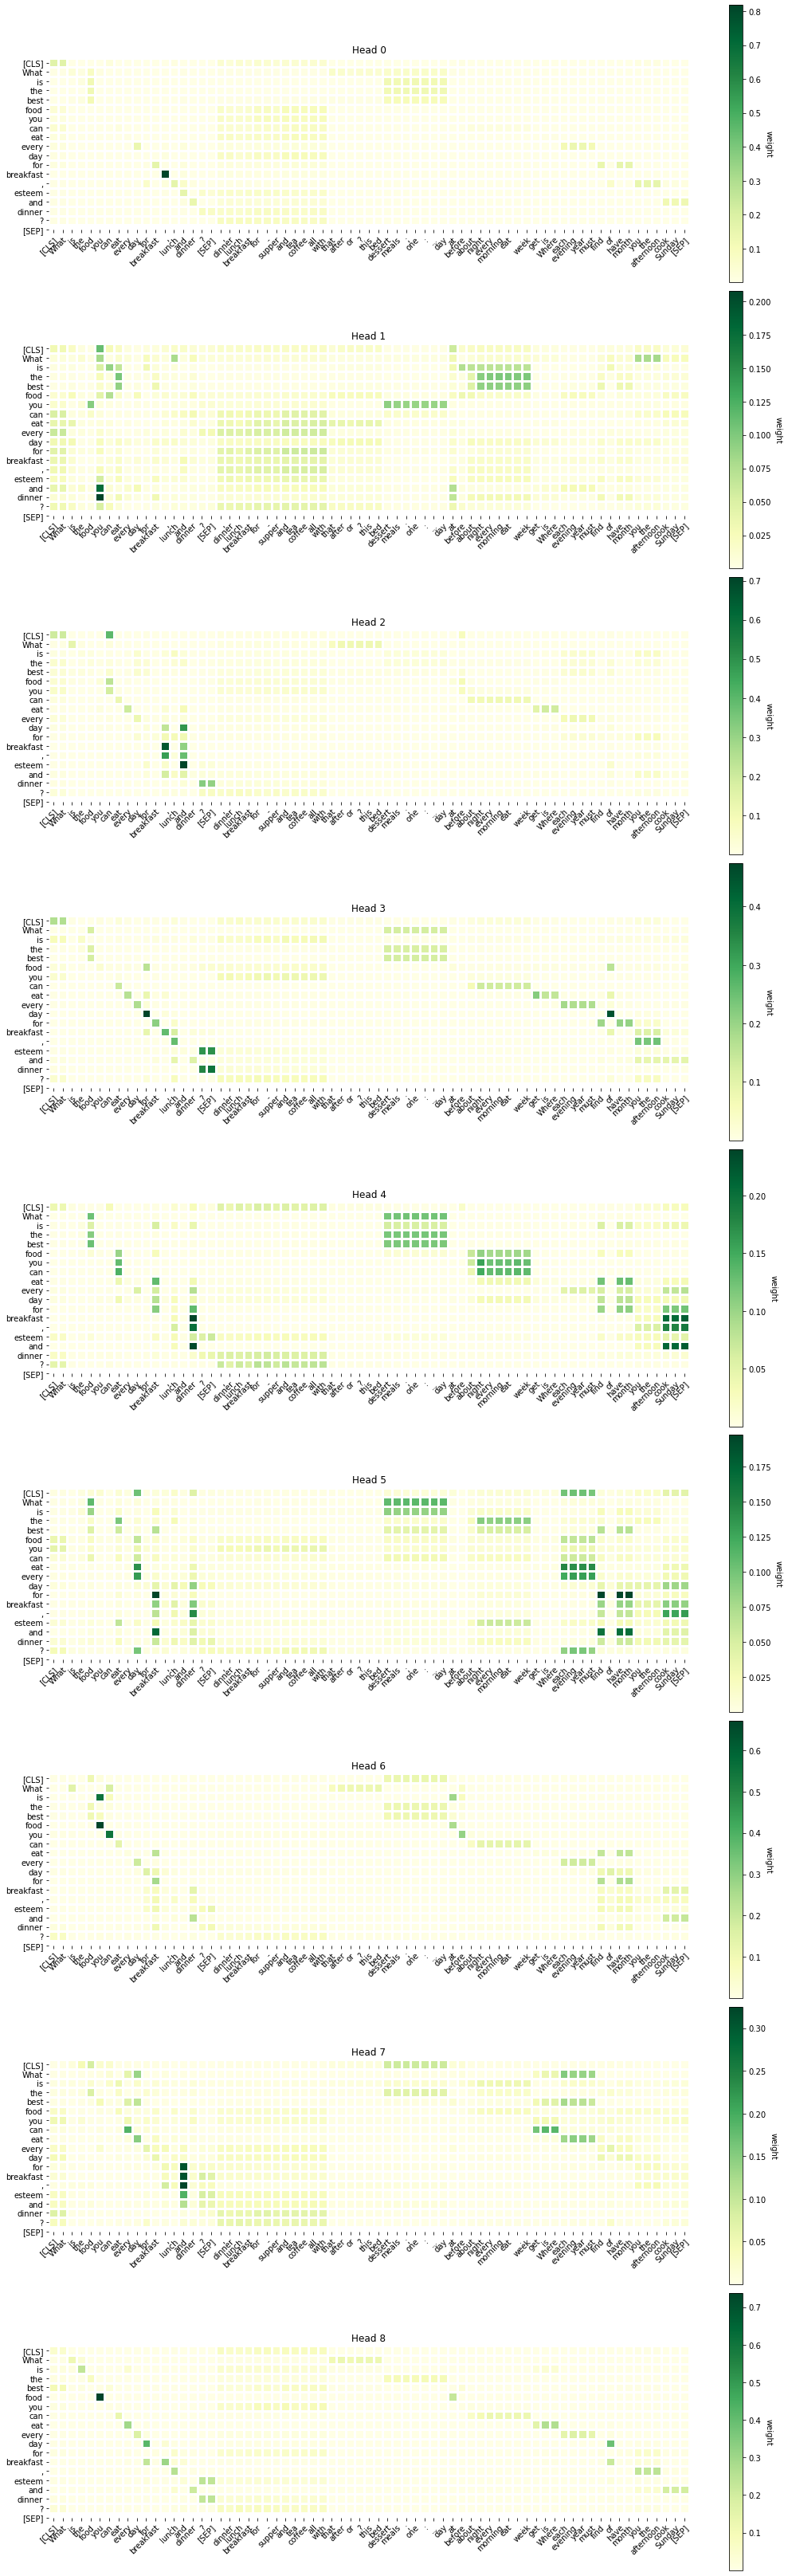

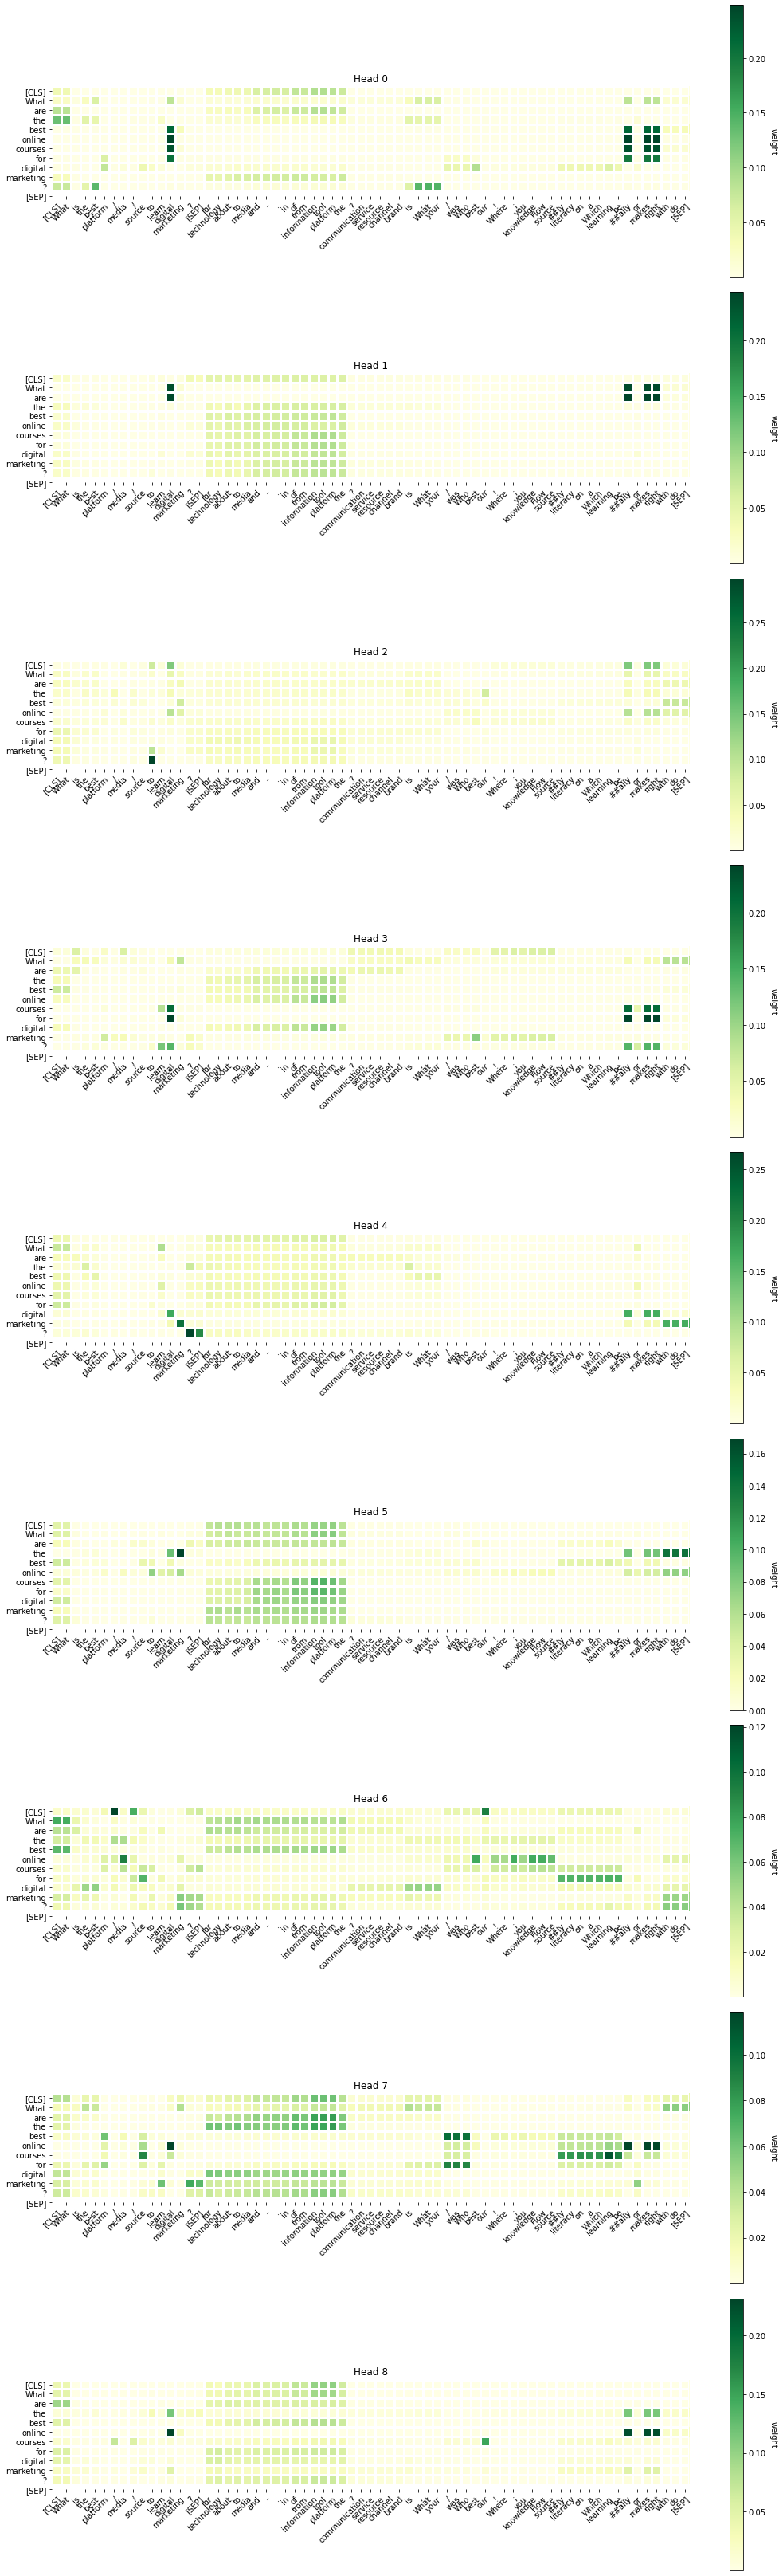

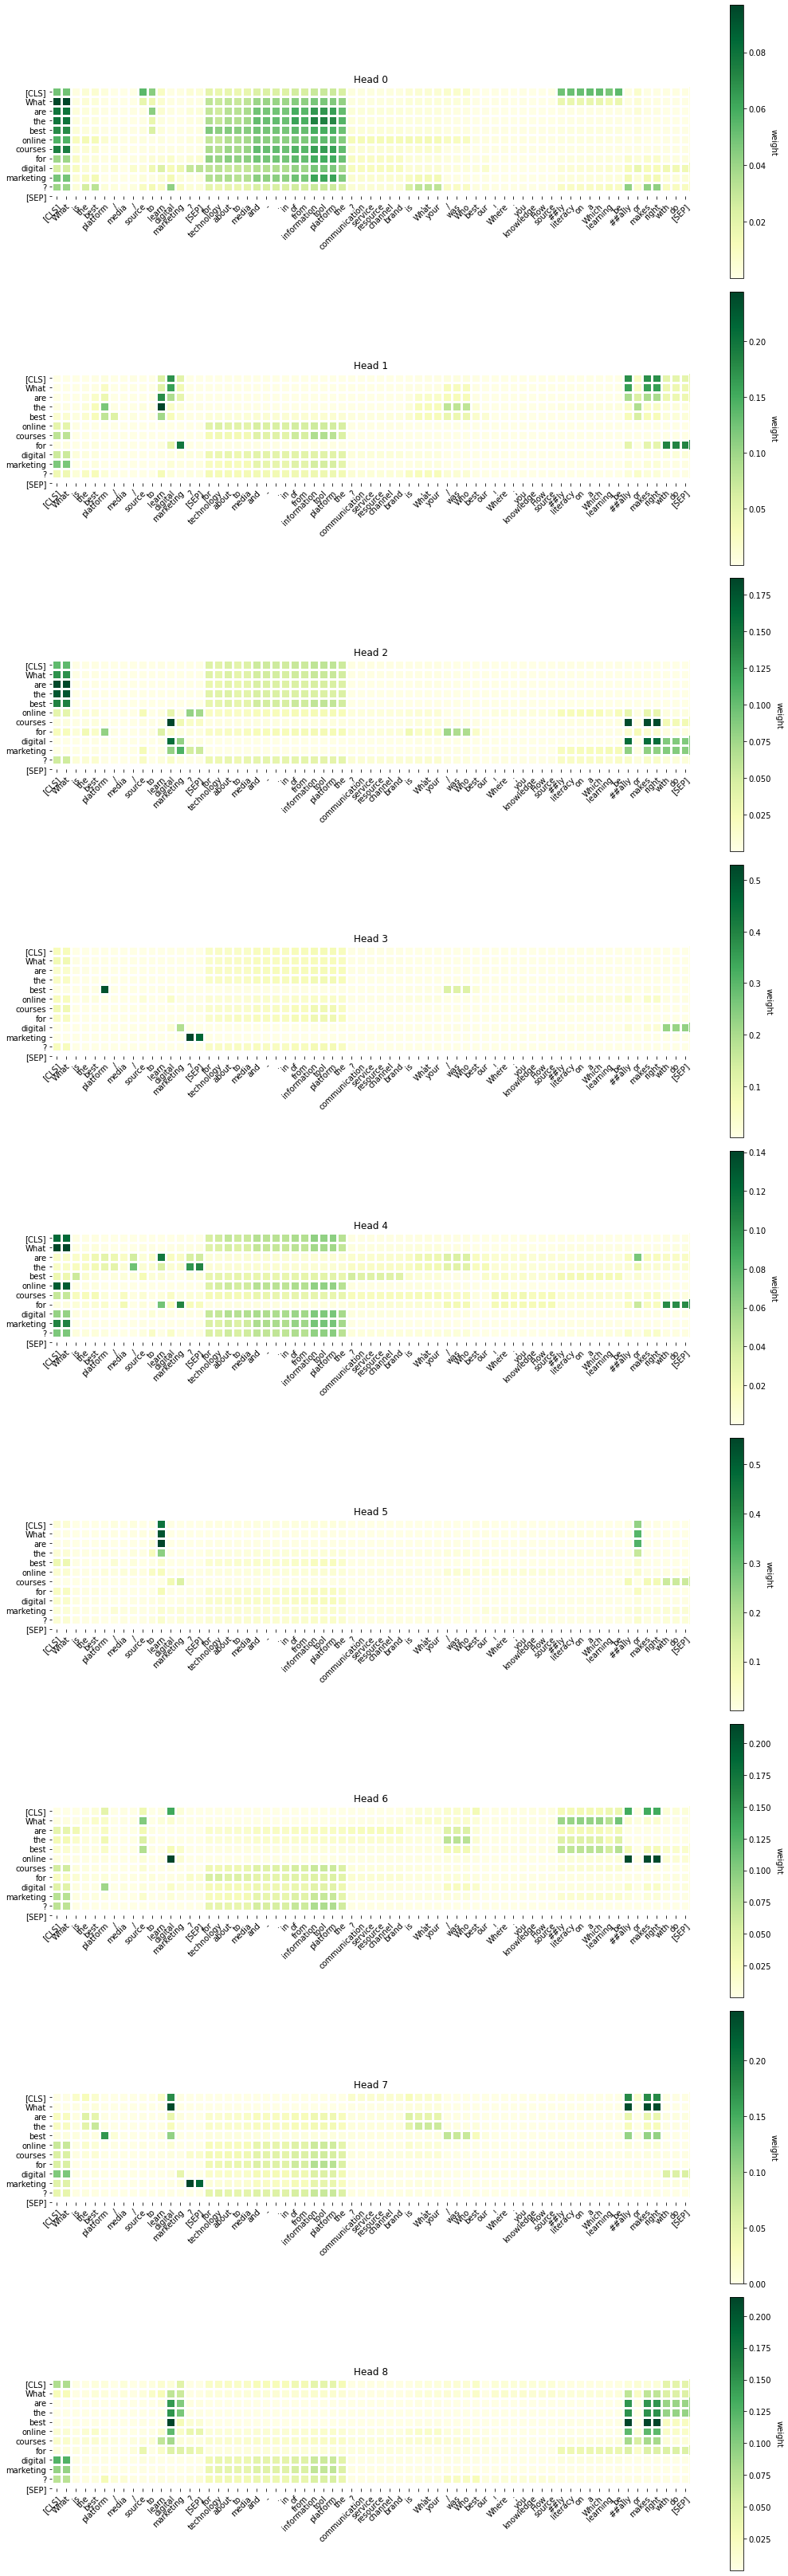

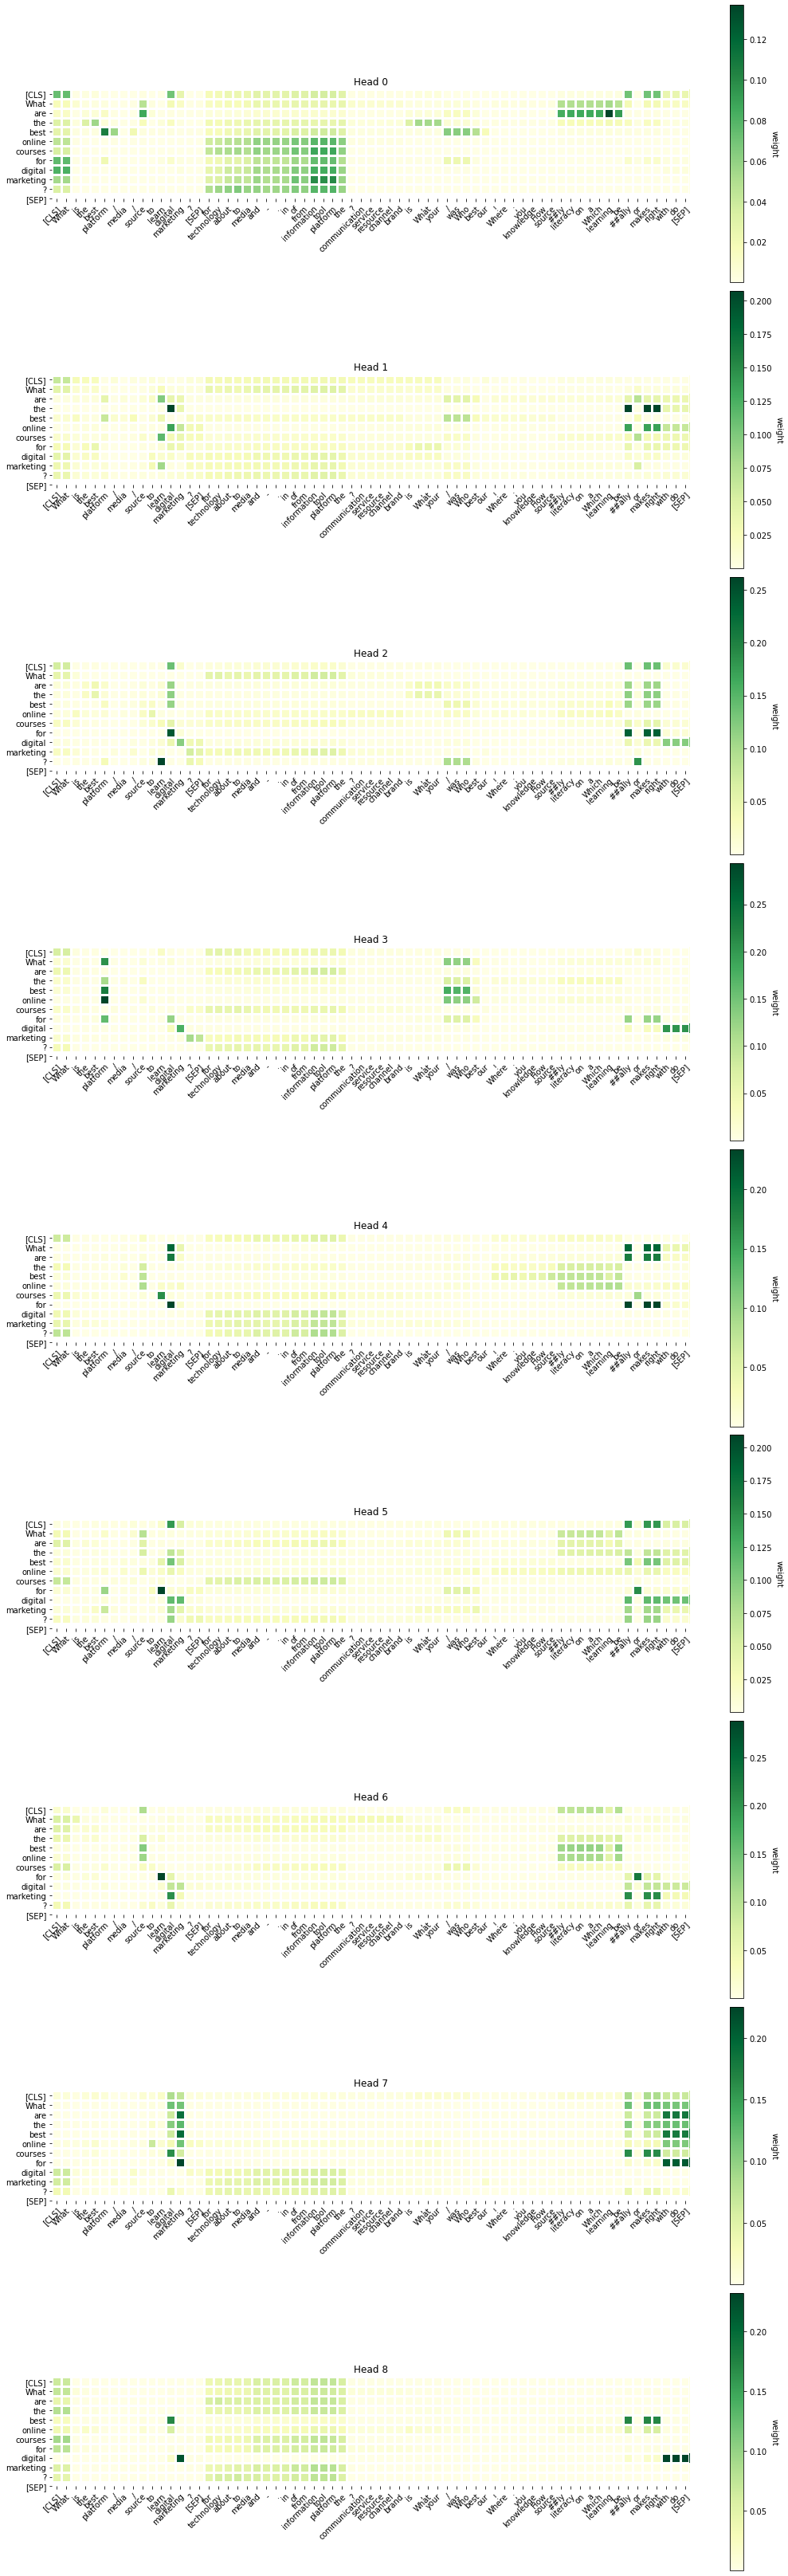

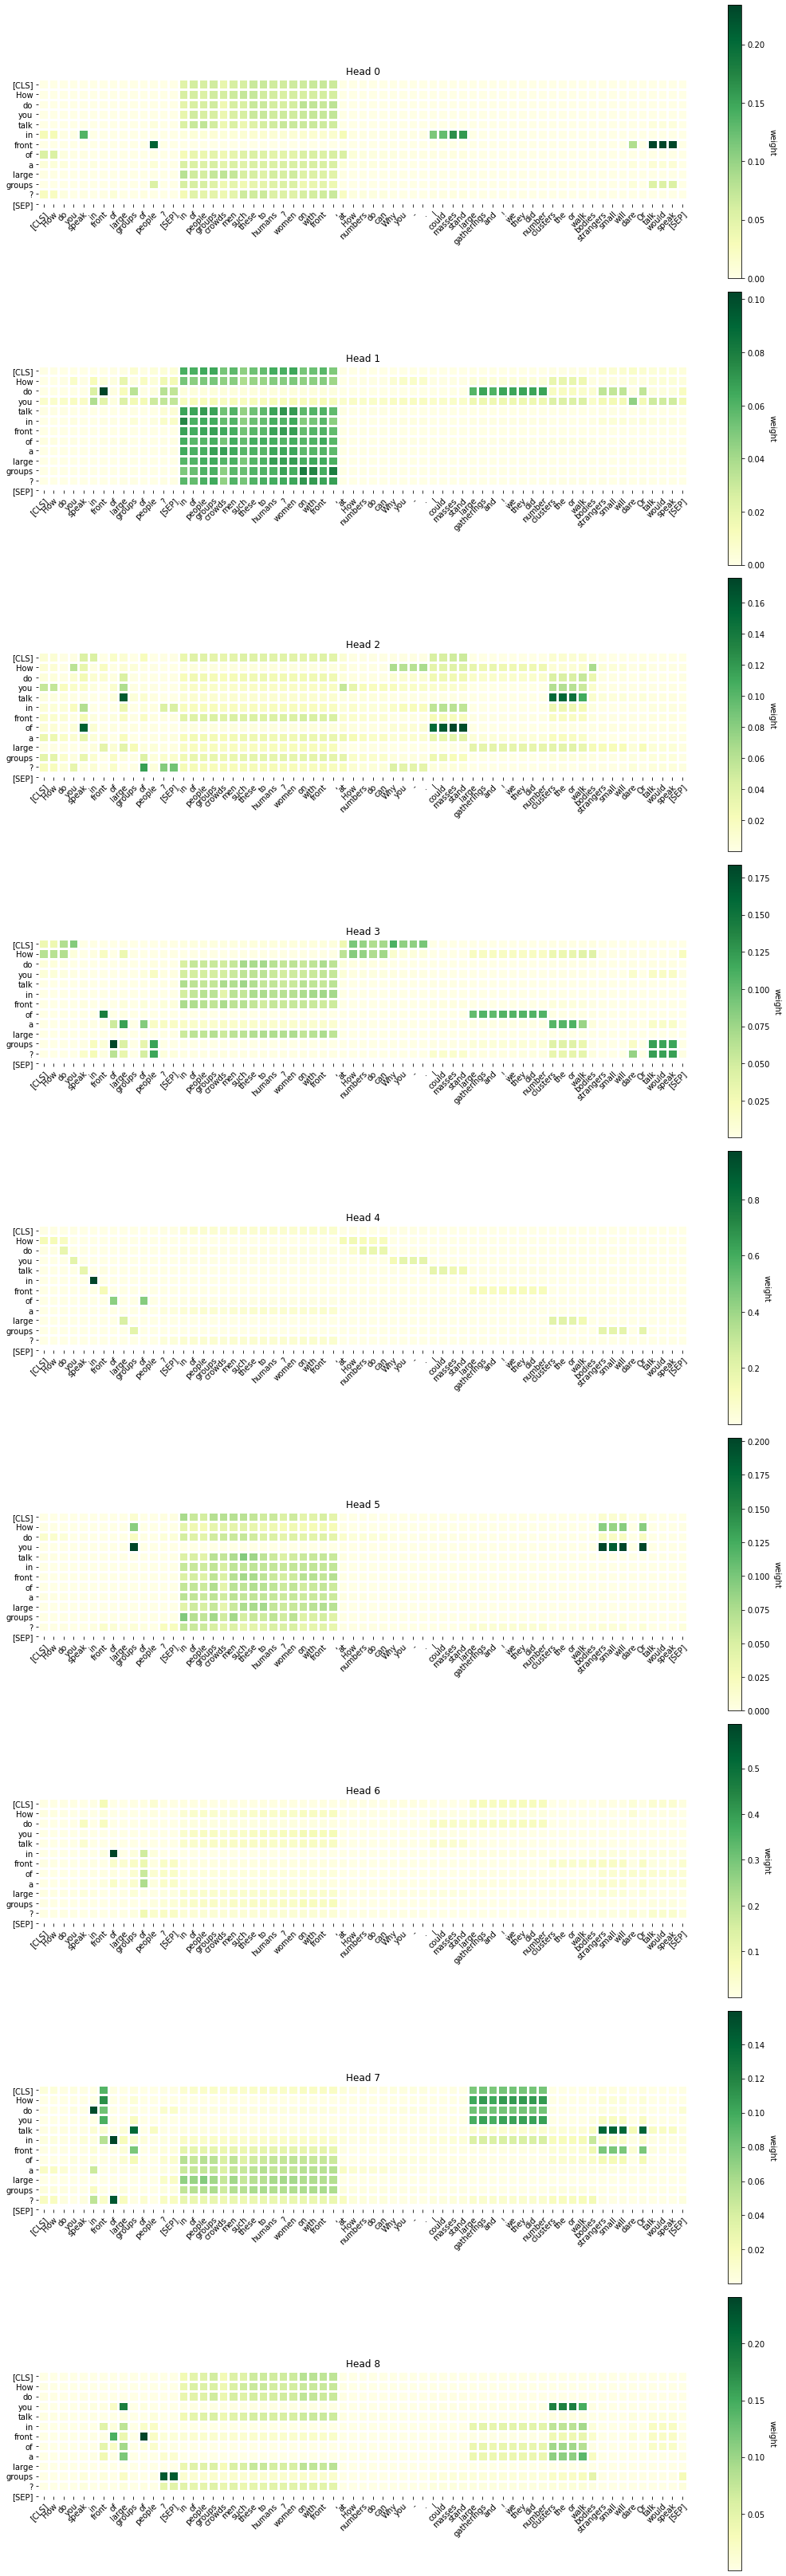

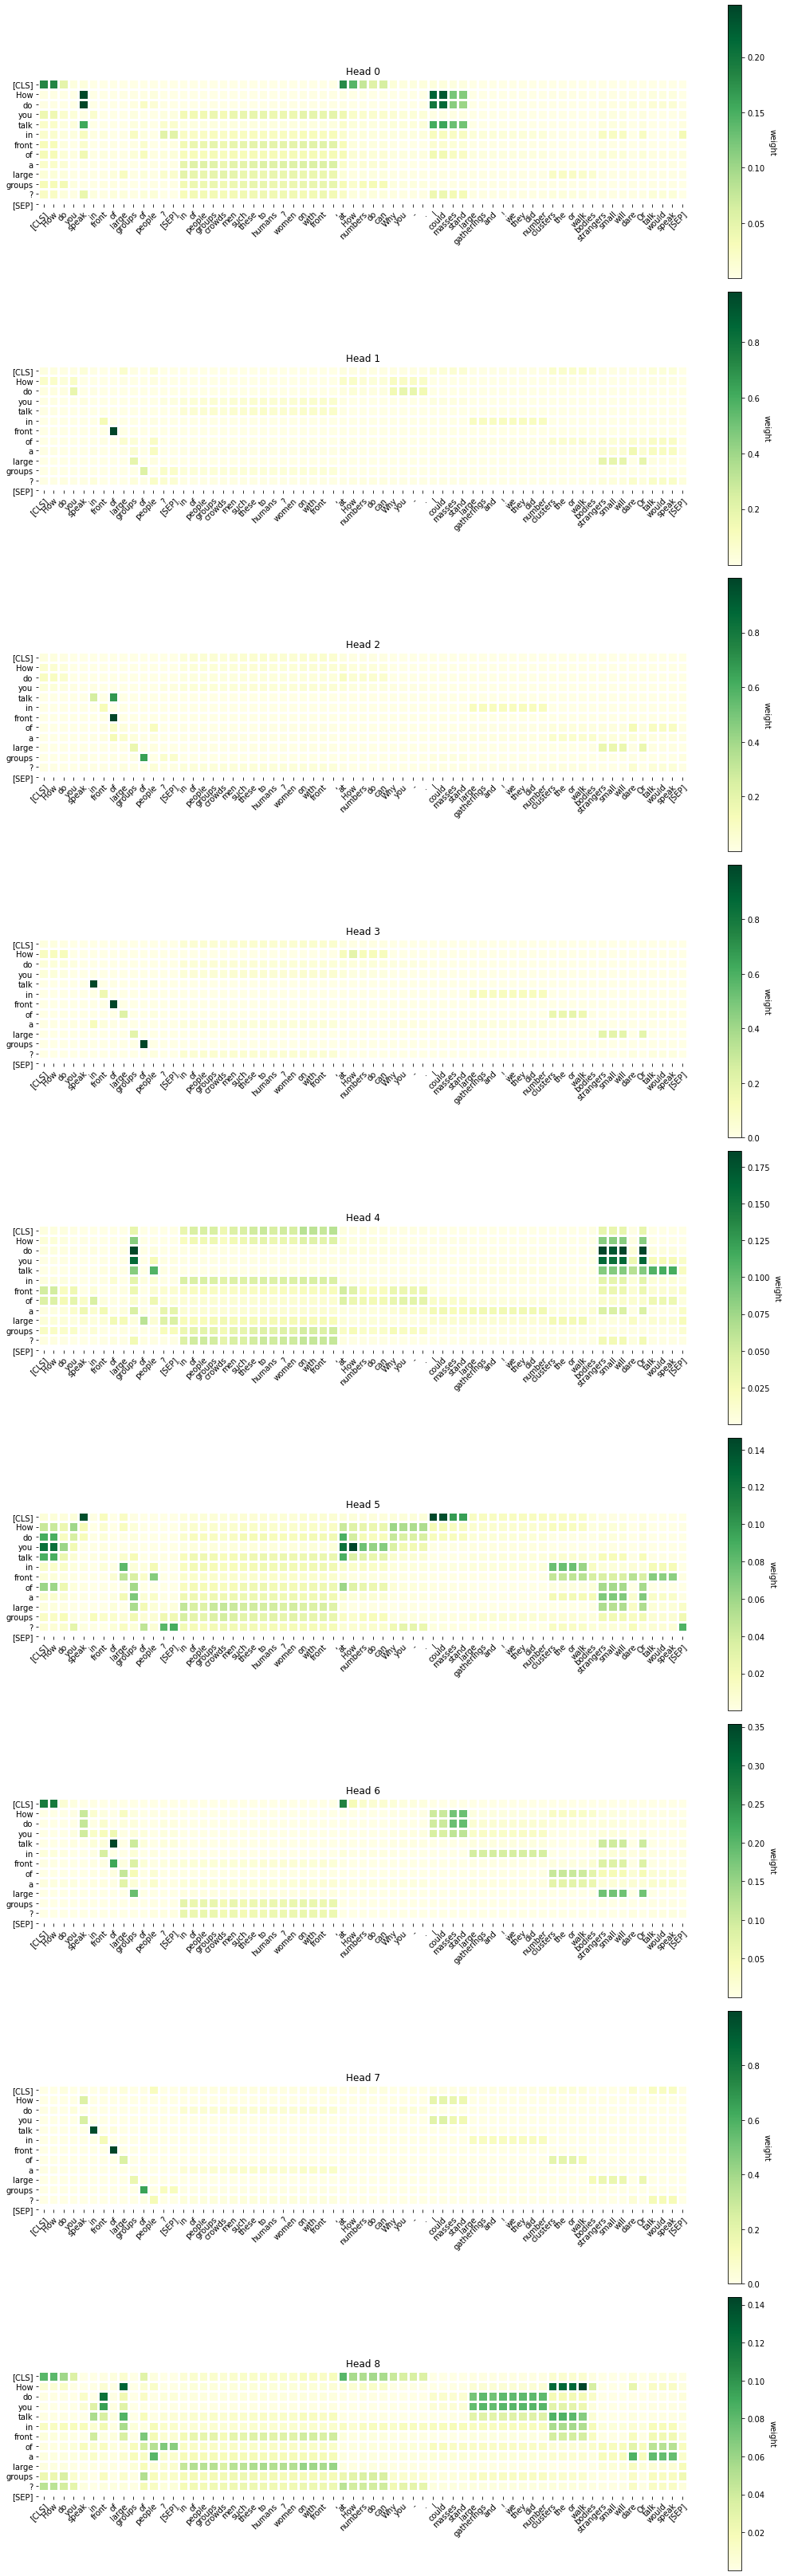

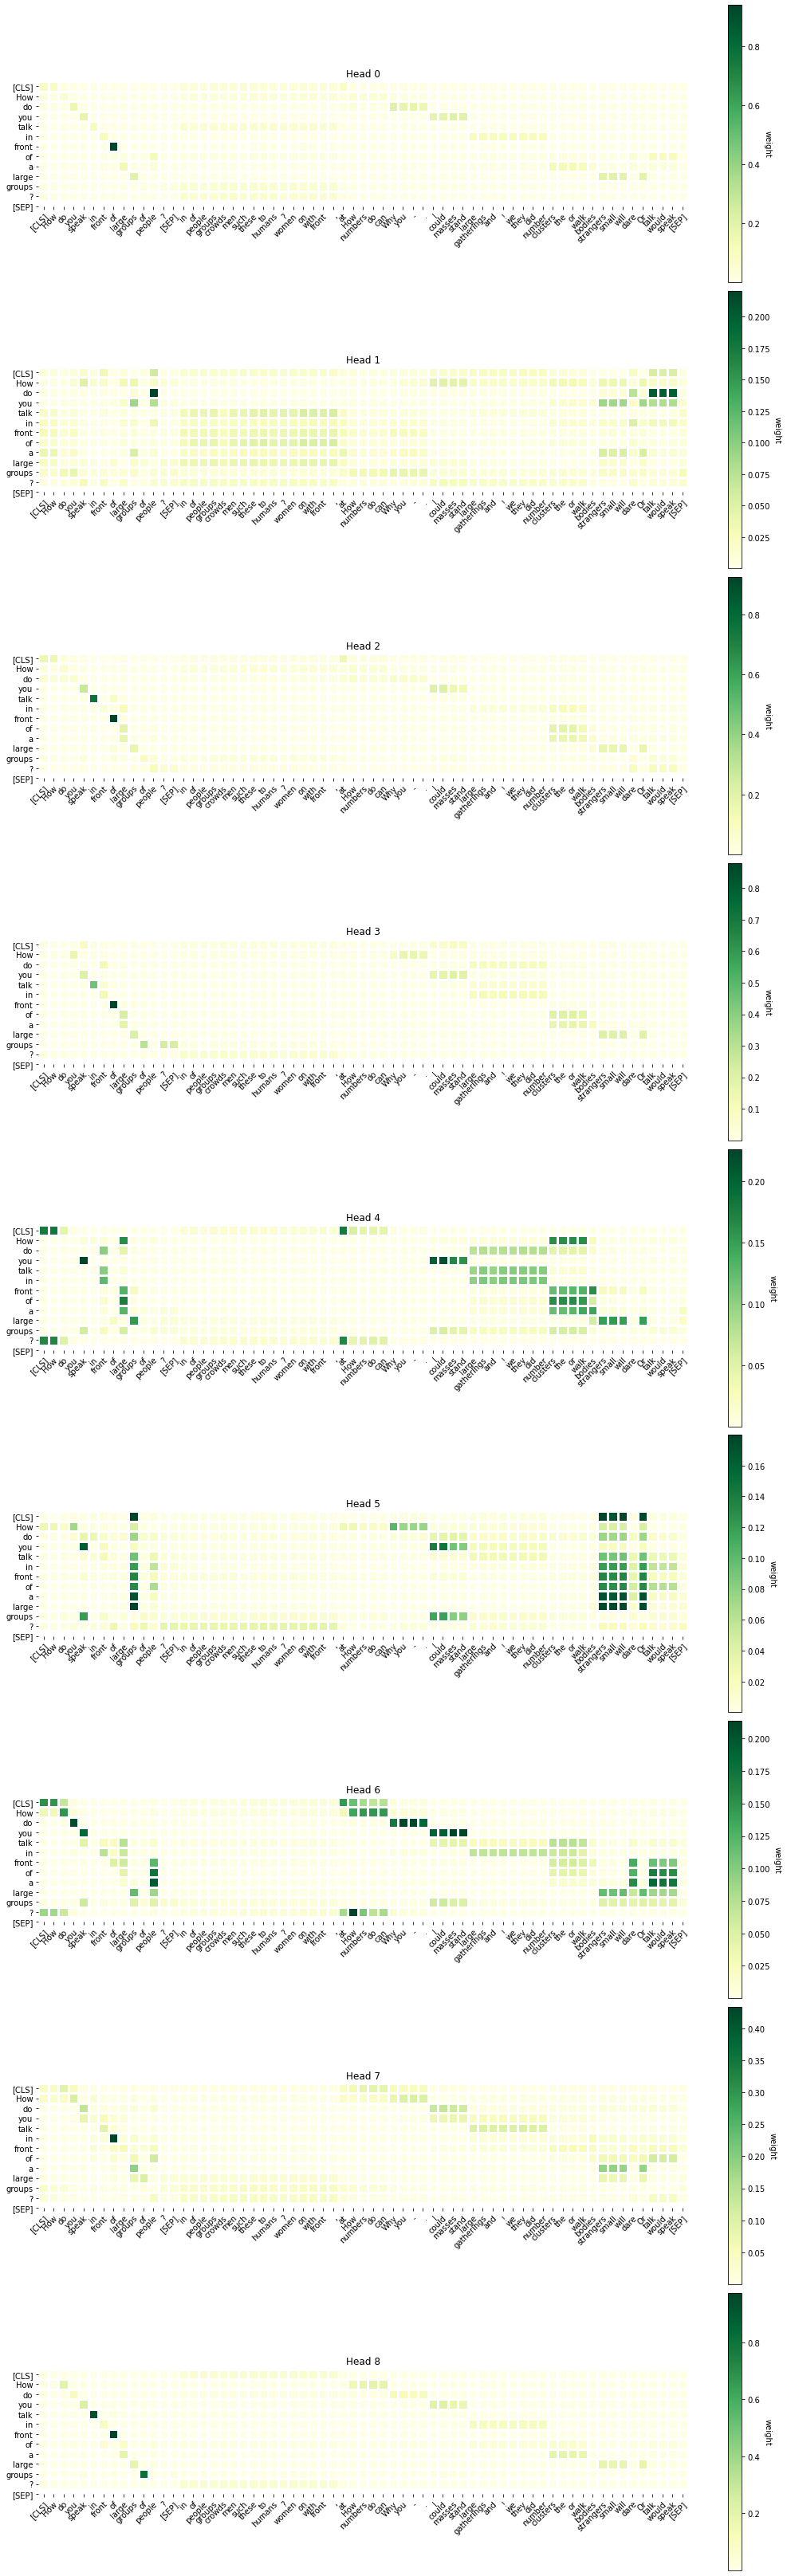

In [13]:
idxs = [0, 15, 31]
for idx in idxs:
    seq1, seq2 = dataset[idx]

    seq1 = seq1.reshape(1, -1)
    seq2 = seq2.reshape(1, -1)

    src_seq = seq1.to(device)
    trg_seq = seq2[:,:-1].to(device)
    gold = seq2[:, 1:].contiguous().view(-1).to(device)
    
    with torch.no_grad():
        # shape of output_dec_enc_attn:
        # list of layers with length = number of layers (3 here)
        # layer * ( beam_size * number of heads * output length *  input length)
        pred_seq, output_dec_enc_attn = translator.translate_sentence(src_seq, return_attn=True)
        # pred, enc_slf_attn_list, dec_slf_attn_list, dec_enc_attn_list = model(src_seq, trg_seq, True)
    
    src, output = get_src_pred(dataset, idx, config_path)
    
    model_name = config_path.split('/')[-1][:-5]
    draw_attention(src, output, output_dec_enc_attn, model_name, idx, savefig=True)

In [14]:
# idx = 0
# seq1, seq2 = dataset[idx]

# seq1 = seq1.reshape(1, -1)
# seq2 = seq2.reshape(1, -1)

# src_seq = seq1.to(device)
# trg_seq = seq2[:,:-1].to(device)
# gold = seq2[:, 1:].contiguous().view(-1).to(device)



In [15]:
# with torch.no_grad():
#     # shape of output_dec_enc_attn:
#     # list of layers with length = number of layers (3 here)
#     # layer * ( beam_size * number of heads * output length *  input length)
#     pred_seq, output_dec_enc_attn = translator.translate_sentence(src_seq, return_attn=True)
    
#     # pred, enc_slf_attn_list, dec_slf_attn_list, dec_enc_attn_list = model(src_seq, trg_seq, True)

In [16]:
# # not bert
# src = [dataset.idx2word[idx] for idx in src_seq[0].tolist()]
# output = [dataset.idx2word[idx] for idx in pred_seq]
# # output = [dataset.idx2word[idx] for idx in trg_seq[0].tolist()]
# print("src: ", src)
# print("output: ", output)

In [17]:
# # bert
# tokenizer = dataset.tokenizer
# src = tokenizer.convert_ids_to_tokens(src_seq[0])
# output = tokenizer.convert_ids_to_tokens(pred_seq)
# target = tokenizer.convert_ids_to_tokens(trg_seq[0])

# print("Src: ", src)
# print("Output: ", output)
# print("Target: ", target)